In [3]:
import os
import sys
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

# Get the current working directory
current_folder = os.getcwd()

# # Add a relative path (e.g., parent folder or a specific subfolder)
SpeedNet_model_folder = os.path.abspath(os.path.join(current_folder, "../../SpeedNet_model"))
sys.path.append(SpeedNet_model_folder)

hsemetric_folder = os.path.abspath(os.path.join(current_folder, "../../HSEMETRIC"))
sys.path.append(hsemetric_folder)

hssactivation_metrics_folder = os.path.abspath(os.path.join(current_folder, "../../HSS_Activation_metrics"))
sys.path.append(hssactivation_metrics_folder)


# Now import the module
import SpeedNet_model_prep #(I created the package to allow easy flow extraction from the pretrained model)
import HSS_activation_metric
import hsemetric        #(This package was created by Upendra et al. 2020)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from keras.models import load_model

In [5]:
def save_data_csv(test_timestamps_output, test_velocity_out, best_pred, phase, fold_index, num_delay, n_steps=1):
    """
    test_timestamps_output: list of timestamp
    test_velocity_out: list of the original values
    best_pred: list of prediction
    phase: STRING --> solar cycle phase
    fold_index: cross-validation fold
    num_delay: data adapation delay; note that index starts from 0.
    n_steps: Default timesteps is equal to 1.
    """
    data_pred = {
            'date': test_timestamps_output[(n_steps-1):],
            'test_original': tf.squeeze(test_velocity_out[(n_steps-1):]),
            'test_predicted': tf.squeeze(best_pred)
        }
    pred_df = pd.DataFrame(data_pred)

    # Create a complete date range from the minimum to the maximum date in the data
    pred_date_range = pd.date_range(start=pred_df['date'].min(), end=pred_df['date'].max())

    # Reindex the DataFrame to insert NaN for missing dates
    pred_df = pred_df.set_index('date').reindex(pred_date_range).rename_axis('date').reset_index()

    pred_df.to_csv(f'{phase}_{fold_index}_and_delay_{num_delay+1}.csv', index=False)

In [6]:
def whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel):
   
    train_start_date = "2010-05-13"
    train_end_date = "2018-12-31"
    test_start_date = "2019-01-01"
    test_end_date = "2019-12-31"
    n_steps = 1
    
    df, velocity_train, velocity_test, std_velocity_test, train_speed_dates, test_speed_dates, full_icme_list = SpeedNet_model_prep.load_df(path, train_start_date,
                                                                                                                                            train_end_date, test_start_date, 
                                                                                                                                            test_end_date)

    map_train_non_icme_date, map_test_non_icme_date = SpeedNet_model_prep.non_icme_Image_date(img_train_path, img_test_path, full_icme_list)
    
    Speed_train_indices, Speed_test_indices, solar_image_train_indices, solar_image_test_indices = SpeedNet_model_prep.time_adaptation_delay_prep(train_start_date,train_end_date,
                                                                                                                                                test_start_date,test_end_date,train_speed_dates, test_speed_dates,
                                                                                                                                                map_train_non_icme_date, map_test_non_icme_date)
    
    full_period_Train_image_cnn_date, full_period_Train_timeseries_date, full_period_Train_output_timeseries_date = SpeedNet_model_prep.cnn_data_prep(full_period_num_delay,
                                                                                                                                                      n_steps, map_train_non_icme_date, 
                                                                                                                                                      train_speed_dates, 
                                                                                                                                                      solar_image_train_indices, Speed_train_indices)  
      
    full_period_Test_image_cnn_date, full_period_Test_timeseries_date, full_period_Test_output_timeseries_date = SpeedNet_model_prep.cnn_data_prep(full_period_num_delay,
                                                                                                                                                   n_steps, map_test_non_icme_date,
                                                                                                                                                   test_speed_dates,
                                                                                                                                                   solar_image_test_indices, Speed_test_indices)

    full_period_velocity_out, full_period_test_velocity_out, full_period_test_timestamps_output = SpeedNet_model_prep.filter_output(df, full_period_Train_output_timeseries_date, full_period_Test_output_timeseries_date)
    
    full_period_train_images, full_period_test_images =  SpeedNet_model_prep.train_test_set(img_train_path, img_test_path, full_period_Train_image_cnn_date,full_period_Test_image_cnn_date)

    if channel == 1:
        SpeedNet_model = load_model(f"/home/joseph/DL/SpeedNet-BM/FULL_CYCLE/save_data/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{full_period_num_delay}.keras")
        
        
    else:
        SpeedNet_model = load_model(f"/home/joseph/DL/SpeedNet-EUV/FULL_CYCLE/save_data/best_model_for_fold_{fold_index}_timestep_{n_steps}_and_delay_{full_period_num_delay}.keras")
        

    return full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model
    
    

# SpeedNet-EUV

In [ ]:
path = "/home/joseph/DL/DATASET"
img_train_path = "/home/joseph/DL/DATA_SPLITTING/FULL_CYCLE_CHANNEL/Train"
img_test_path = "/home/joseph/DL/DATA_SPLITTING/FULL_CYCLE_CHANNEL/Test"

### Delay == 1

In [29]:
channel = 3 
full_period_num_delay = 0
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model= whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model_delay_1)
    


11/11 [==============================] - 1s 56ms/step


### Delay == 2

In [30]:
channel = 3 
full_period_num_delay = 1
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model= whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 56ms/step


### Delay == 3

In [31]:
channel = 3 
full_period_num_delay = 2
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 56ms/step


### Delay == 4

In [32]:
channel = 3 
full_period_num_delay = 3
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 56ms/step


### Delay == 5

In [33]:
channel = 3 
full_period_num_delay = 4
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


10/10 [==============================] - 1s 55ms/step


# SpeedNet-BM

In [ ]:
path = "/home/joseph/DL/DATASET"
img_train_path = "/home/joseph/DL/DATASET/FULL_CYCLE_BINARY/Train"
img_test_path = "/home/joseph/DL/DATASET/FULL_CYCLE_BINARY/Test"

### Delay 1

In [34]:
channel = 1 
full_period_num_delay = 0
fold_index = 1

full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 46ms/step


### Delay 2

In [35]:
channel = 1 
full_period_num_delay = 1
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 45ms/step


### Delay 3

In [36]:
channel = 1 
full_period_num_delay = 2
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, best_model_full_period_2019_delay_1 = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, best_model_full_period_2019_delay_1)
    


11/11 [==============================] - 1s 46ms/step


### Delay 4

In [37]:
channel = 1 
full_period_num_delay = 3
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


11/11 [==============================] - 1s 44ms/step


### Delay 5

In [38]:
channel = 1 
full_period_num_delay = 4
fold_index = 1
full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model = whole_processing(path, img_train_path, img_test_path, full_period_num_delay,fold_index, channel)
channel_delay_1_hss_csv = HSS_activation_metric.HSS_activation_csv(channel, full_period_test_velocity_out, full_period_test_images, full_period_Test_timeseries_date, full_period_num_delay, SpeedNet_model)
    


10/10 [==============================] - 1s 44ms/step


### Read the data

In [39]:
for i in range(5):
    globals()[f"SpeedNet_EUV_delay_{i+1}"] = pd.read_csv(f'/home/joseph/DL/PLOT_VISUAL/HSSs_Activation_comparison_Analysis/Channel_HSS_Gradcam_activation_metrics_delay_{i}.csv')
    globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"] = globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"].astype(str).str[-22:-11]
    globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"] = pd.to_datetime(globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"])


In [40]:
for i in range(5):
    globals()[f"SpeedNet_BM_delay_{i+1}"] = pd.read_csv(f'/home/joseph/DL/PLOT_VISUAL/HSSs_Activation_comparison_Analysis/Binary_HSS_Gradcam_activation_metrics_delay_{i}.csv')
    globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"] = globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"].astype(str).str[-22:-11]
    globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"] = pd.to_datetime(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"])



#### Now let' Plot

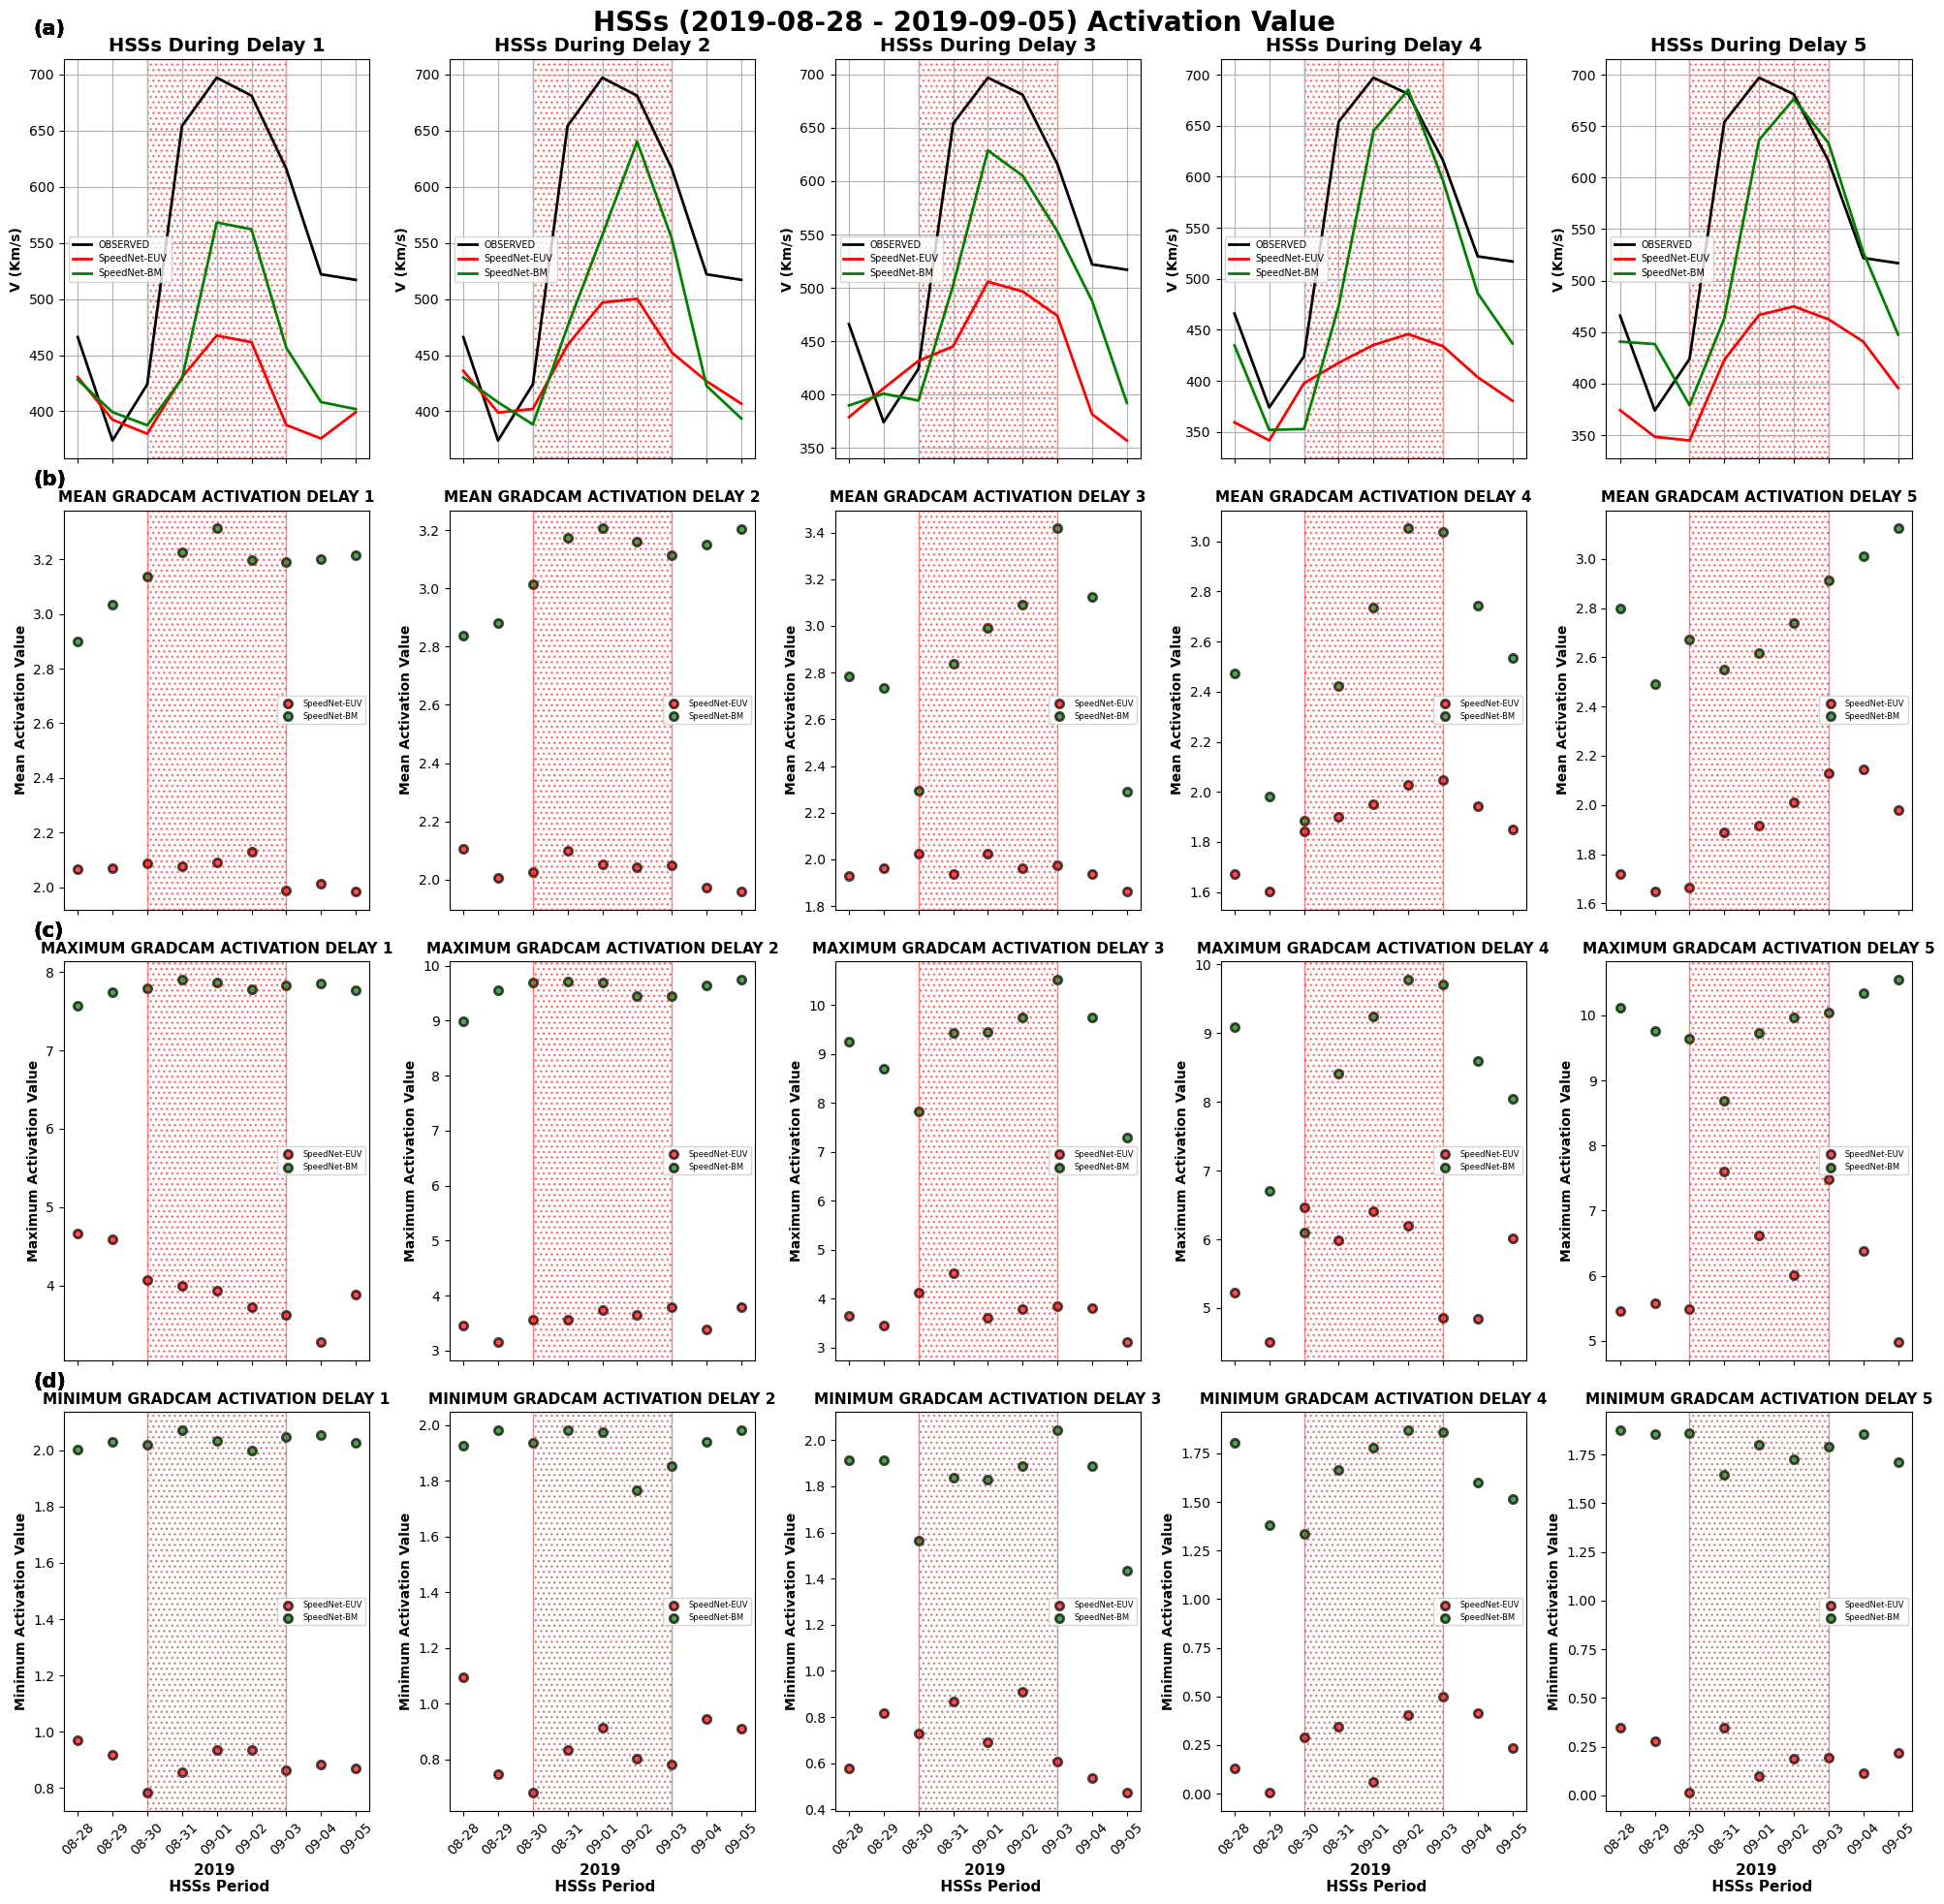

In [42]:
fig, ax = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
fig.suptitle(f'HSSs ({globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][0].strftime("%Y-%m-%d")} - {globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][8].strftime("%Y-%m-%d")}) Activation Value', fontsize = 20, fontweight = "bold")
for i in range(5):
    # ROW 1
    # Original data
    ax[0, i].plot(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{i+1}"]["Original_HSS"], linestyle='-', color='black', linewidth=2,  label='OBSERVED')
    #SpeedNet-EUV Prediction
    ax[0, i].plot(globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{i+1}"]["Predicted_HSS"], linestyle='-', color='r', linewidth=2,  label='SpeedNet-EUV')
    # SpeedNet-BM Prediction
    ax[0, i].plot(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{i+1}"]["Predicted_HSS"], linestyle='-', color='g', linewidth=2,  label='SpeedNet-BM')
    ax[0, i].axvspan(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5) 

    # ax[0, i].text(0.1, 0.3, 'HSSs Region', fontsize=14,  weight='bold', color='black', ha='center', va='center')
    ax[0, i].tick_params(axis="x", rotation=45)
    ax[0, i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[0, i].set_title(f'HSSs During Delay {i+1}', fontsize = 14, fontweight = "bold")
    ax[0,i].legend(fontsize=7, loc='center left')
    ax[0,i].set_ylabel('V (Km/s)', fontsize = 10, fontweight = "bold")
    ax[0,i].grid("on")
    ax[0, 0].text(-0.1, 1.1, '(a)', transform=ax[0,0].transAxes, fontsize=15, fontweight='bold', va='top', ha='left')


    
    # ROW 2
    # SpeedNet-EUV Mean Activation
    ax[1, i].scatter(globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{i+1}"]["Mean_act"], linestyle='-', color='r', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Mean Activation
    ax[1, i].scatter(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{i+1}"]["Mean_act"], linestyle='-', color='g', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-BM')
    ax[1, i].set_title(f'MEAN GRADCAM ACTIVATION DELAY {i+1}', fontsize = 11, fontweight = "bold")
    ax[1, i].tick_params(axis="x", rotation=45)
    ax[1, i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[1, i].set_ylabel('Mean Activation Value', fontsize = 10, fontweight = "bold")
    ax[1, 0].text(-0.1, 1.1, '(b)', transform=ax[1, 0].transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    # ax[1, i].grid("on")
    ax[1, i].legend(fontsize=6, loc='center right')
    ax[1, i].axvspan(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSSs')

    # ROW 3
    # SpeedNet-EUV Maximum Activation
    ax[2, i].scatter(globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{i+1}"]["Max_act"], linestyle='-', color='r', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Maximum Activation
    ax[2, i].scatter(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{i+1}"]["Max_act"], linestyle='-', color='g', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-BM')
    ax[2, i].set_title(f'MAXIMUM GRADCAM ACTIVATION DELAY {i+1}', fontsize = 11, fontweight = "bold")
    ax[2, i].tick_params(axis="x", rotation=45)
    ax[2, i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[2, i].set_ylabel('Maximum Activation Value', fontsize = 10, fontweight = "bold")
    ax[2, 0].text(-0.1, 1.1, '(c)', transform=ax[2,0].transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    # ax[2, i].grid("on")
    ax[2, i].legend(fontsize=6, loc='center right')
    ax[2, i].axvspan(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSSs')
   
    
    # ROW 4
    # SpeedNet-EUV Minimum Activation
    ax[3, i].scatter(globals()[f"SpeedNet_EUV_delay_{i+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{i+1}"]["Min_act"], linestyle='-', color='r', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Minimum Activation
    ax[3, i].scatter(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{i+1}"]["Min_act"], linestyle='-', color='g', alpha=0.7, edgecolor='black', linewidth=2, label= 'SpeedNet-BM')
    ax[3, i].set_title(f'MINIMUM GRADCAM ACTIVATION DELAY {i+1}', fontsize = 11, fontweight = "bold")
    ax[3, i].tick_params(axis="x", rotation=45)
    ax[3, i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[3, i].set_ylabel('Minimum Activation Value', fontsize = 10, fontweight = "bold")
    ax[3, 0].text(-0.1, 1.1, '(d)', transform=ax[3, 0].transAxes, fontsize=15, fontweight='bold', va='top', ha='left')
    # ax[3, i].grid("on")
    ax[3, i].legend(fontsize=6, loc='center right')
    ax[3, i].axvspan(globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{i+1}"]["Wind_date"][6], facecolor='none', edgecolor='brown', hatch='...', alpha=0.5, label='HSSs')
    ax[3, i].set_xlabel('2019 \n HSSs Period', fontsize = 11, fontweight = "bold")
    
plt.tight_layout()
plt.savefig('HSS_ACTIVATION_VALUE_ANALYSIS')
# Show the plot
plt.show()

### FOR DELAY of 4 and 5

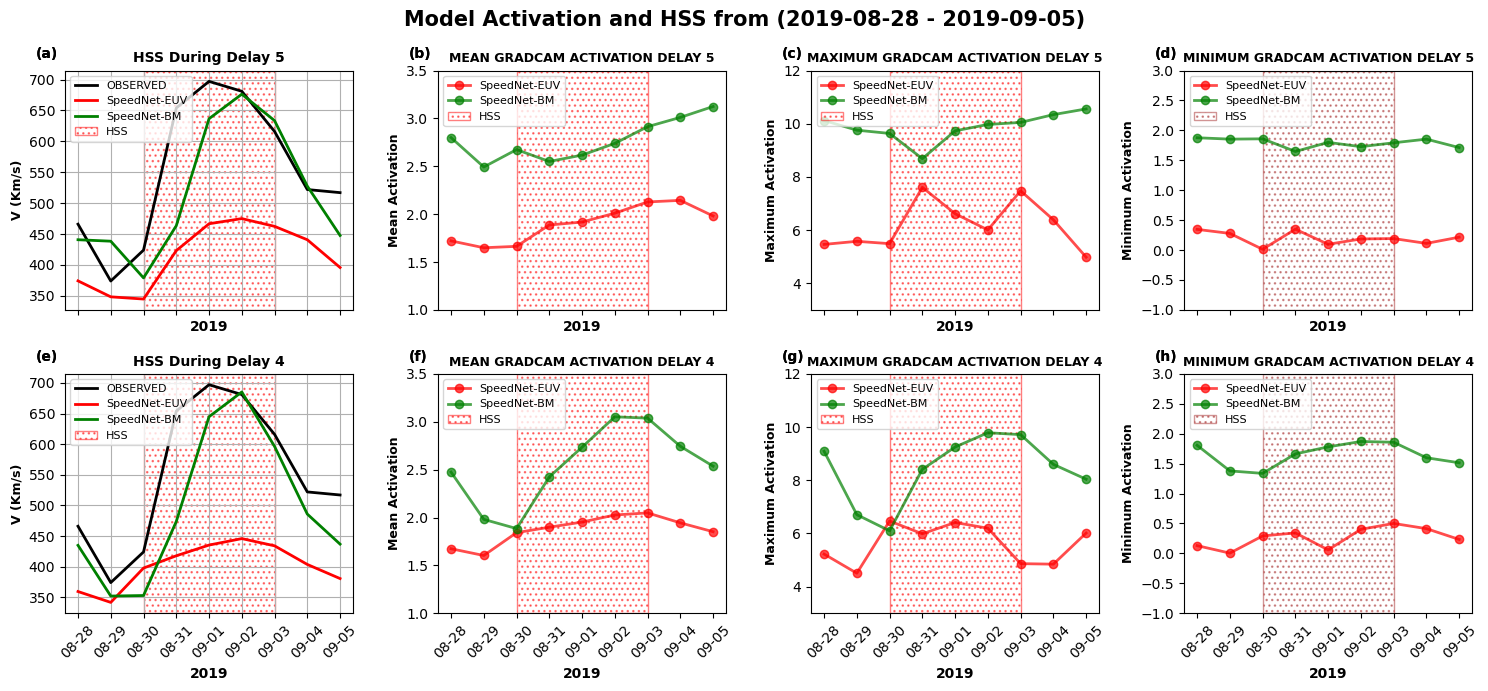

In [60]:
delay_list = [4, 3]
fig, ax = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for i in range(2):
    fig.suptitle(f'Model Activation and HSS from ({globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][0].strftime("%Y-%m-%d")} - {globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][8].strftime("%Y-%m-%d")})', fontsize = 15, fontweight = "bold")
    # Column 1
    # Observed HSS
    ax[i, 0].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Original_HSS"], linestyle='-', color='black', linewidth=2,  label='OBSERVED')
    # SpeedNet-EUV Prediction
    ax[i, 0].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Predicted_HSS"], linestyle='-', color='r', linewidth=2,  label='SpeedNet-EUV')
    # SpeedNet-BM Prediction
    ax[i, 0].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Predicted_HSS"], linestyle='-', color='g', linewidth=2,  label='SpeedNet-BM')
    
    ax[i, 0].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSS')
    ax[i, 0].tick_params(axis="x", rotation=45)
    ax[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 0].set_title(f'HSS During Delay {delay_list[i]+1}', fontsize = 10, fontweight = "bold")
    ax[i, 0].legend(fontsize=8, loc='center left')
    ax[i, 0].set_ylabel('V (Km/s)', fontsize = 9, fontweight = "bold")
    ax[i, 0].grid("on")
    ax[0, 0].text(-0.1, 1.1, '(a)', transform=ax[0 ,0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 0].text(-0.1, 1.1, '(e)', transform=ax[1 ,0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[i, 0].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 0].legend(loc="upper left", fontsize =8) 
    
    # Column 2
    # SpeedNet-EUV Mean Activation
    ax[i, 1].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Mean_act"], linestyle='-', color='r', alpha=0.7, marker='o', linewidth=2, label= 'SpeedNet-EUV') ##edgecolor='black')
    # SpeedNet-BM Mean Activation
    ax[i, 1].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Mean_act"], linestyle='-', color='g', alpha=0.7, marker='o', linewidth=2, label= 'SpeedNet-BM') ##, edgecolor='black')
    ax[i, 1].set_title(f'MEAN GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 1].tick_params(axis="x", rotation=45)
    ax[i, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 1].set_ylabel('Mean Activation', fontsize = 9, fontweight = "bold")
    ax[0, 1].text(-0.1, 1.1, '(b)', transform=ax[0, 1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 1].text(-0.1, 1.1, '(f)', transform=ax[1, 1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[1, i].grid("on")
    ax[i, 1].legend(fontsize=8, loc='center right')
    ax[i, 1].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSS')
    ax[i, 1].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 1].set_ylim(1, 3.5)
    ax[i, 1].legend(loc="upper left", fontsize =8) 
    
    
    # Column 3
    # SpeedNet-EUV Maximum Activation
    ax[i, 2].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Max_act"], linestyle='-', color='r', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Maximum Activation
    ax[i, 2].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Max_act"], linestyle='-', color='g', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-BM')
    ax[i, 2].set_title(f'MAXIMUM GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 2].tick_params(axis="x", rotation=45)
    ax[i, 2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 2].set_ylabel('Maximum Activation', fontsize = 9, fontweight = "bold")
    ax[0, 2].text(-0.1, 1.1, '(c)', transform=ax[0,2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 2].text(-0.1, 1.1, '(g)', transform=ax[1,2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[2, i].grid("on")
    ax[i, 2].legend(fontsize=8, loc='center right')
    ax[i, 2].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSS')
    ax[i, 2].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 2].set_ylim(3, 12)
    ax[i, 2].legend(loc="upper left", fontsize =8) 
    
    #Column 4
    # SpeedNet-EUV Minimum Activation
    ax[i, 3].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Min_act"], linestyle='-', color='r', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Minimum Activation
    ax[i, 3].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Min_act"], linestyle='-', color='g', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-BM')
    ax[i, 3].set_title(f'MINIMUM GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 3].tick_params(axis="x", rotation=45)
    ax[i, 3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 3].set_ylabel('Minimum Activation', fontsize = 9, fontweight = "bold")
    ax[0, 3].text(-0.1, 1.1, '(d)', transform=ax[0, 3].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 3].text(-0.1, 1.1, '(h)', transform=ax[1, 3].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[i, 3].grid("on")
    ax[i, 3].legend(fontsize=8, loc='center right')
    ax[i, 3].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='brown', hatch='...', alpha=0.5, label='HSS')
    ax[i, 3].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 3].set_ylim(-1, 3)
    ax[i, 3].legend(loc="upper left", fontsize =8) 

plt.tight_layout()
plt.savefig('HSS_ACTIVATION_plot')
# Show the plot
plt.show()

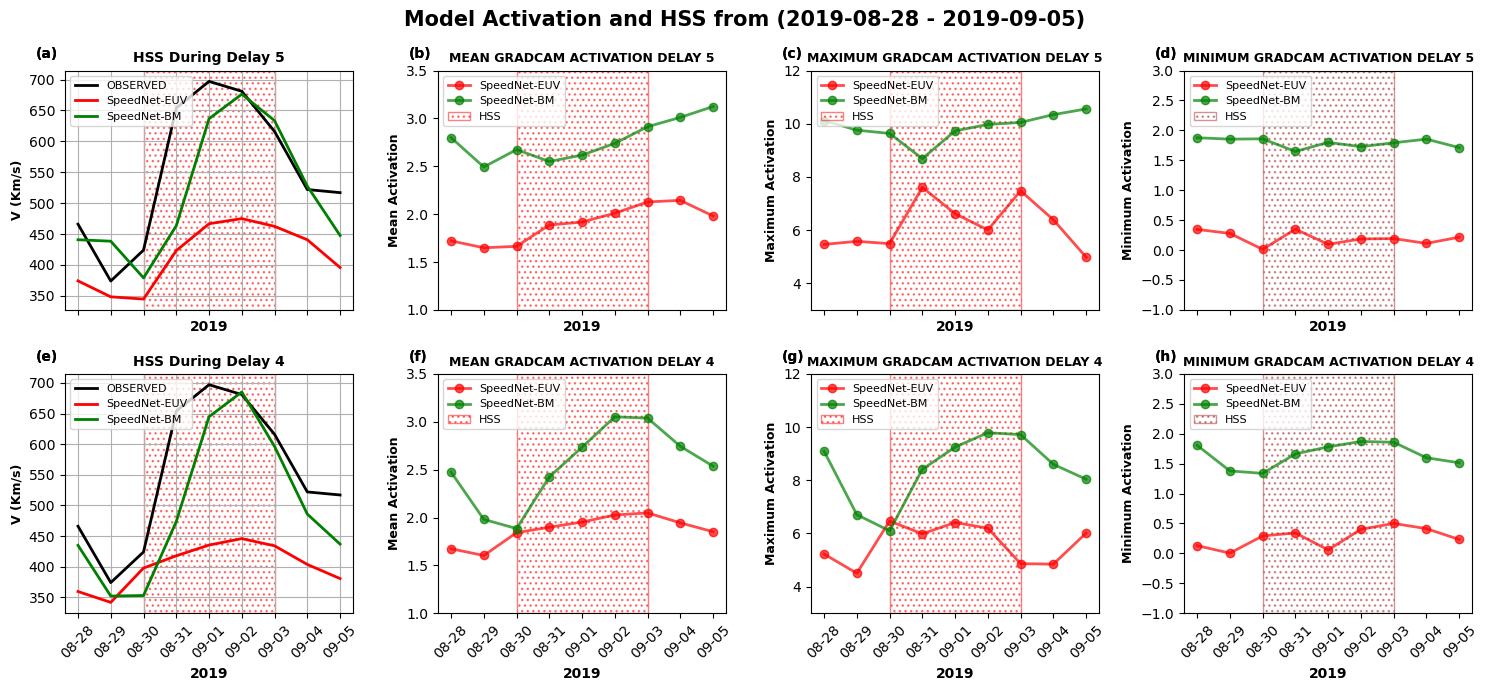

In [61]:
delay_list = [4, 3]
fig, ax = plt.subplots(2, 4, figsize=(15, 7), sharex=True)
for i in range(2):
    fig.suptitle(f'Model Activation and HSS from ({globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][0].strftime("%Y-%m-%d")} - {globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][8].strftime("%Y-%m-%d")})', fontsize = 15, fontweight = "bold")
    # Column 1
    # Observed HSS
    ax[i, 0].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Original_HSS"], linestyle='-', color='black', linewidth=2,  label='OBSERVED')
    # SpeedNet-EUV Prediction
    ax[i, 0].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Predicted_HSS"], linestyle='-', color='r', linewidth=2,  label='SpeedNet-EUV')
    # SpeedNet-BM Prediction
    ax[i, 0].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Predicted_HSS"], linestyle='-', color='g', linewidth=2,  label='SpeedNet-BM')
    
    ax[i, 0].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5)
    ax[i, 0].tick_params(axis="x", rotation=45)
    ax[i, 0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 0].set_title(f'HSS During Delay {delay_list[i]+1}', fontsize = 10, fontweight = "bold")
    ax[i, 0].legend(fontsize=8, loc='center left')
    ax[i, 0].set_ylabel('V (Km/s)', fontsize = 9, fontweight = "bold")
    ax[i, 0].grid("on")
    ax[0, 0].text(-0.1, 1.1, '(a)', transform=ax[0 ,0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 0].text(-0.1, 1.1, '(e)', transform=ax[1 ,0].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[i, 0].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 0].legend(loc="upper left", fontsize =8) 
    
    # Column 2
    # SpeedNet-EUV Mean Activation
    ax[i, 1].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Mean_act"], linestyle='-', color='r', alpha=0.7, marker='o', linewidth=2, label= 'SpeedNet-EUV') ##edgecolor='black')
    # SpeedNet-BM Mean Activation
    ax[i, 1].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Mean_act"], linestyle='-', color='g', alpha=0.7, marker='o', linewidth=2, label= 'SpeedNet-BM') ##, edgecolor='black')
    ax[i, 1].set_title(f'MEAN GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 1].tick_params(axis="x", rotation=45)
    ax[i, 1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 1].set_ylabel('Mean Activation', fontsize = 9, fontweight = "bold")
    ax[0, 1].text(-0.1, 1.1, '(b)', transform=ax[0, 1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 1].text(-0.1, 1.1, '(f)', transform=ax[1, 1].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[1, i].grid("on")
    ax[i, 1].legend(fontsize=8, loc='center right')
    ax[i, 1].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSS')
    ax[i, 1].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 1].set_ylim(1, 3.5)
    ax[i, 1].legend(loc="upper left", fontsize =8) 
    
    
    # Column 3
    # SpeedNet-EUV Maximum Activation
    ax[i, 2].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Max_act"], linestyle='-', color='r', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Maximum Activation
    ax[i, 2].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Max_act"], linestyle='-', color='g', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-BM')
    ax[i, 2].set_title(f'MAXIMUM GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 2].tick_params(axis="x", rotation=45)
    ax[i, 2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 2].set_ylabel('Maximum Activation', fontsize = 9, fontweight = "bold")
    ax[0, 2].text(-0.1, 1.1, '(c)', transform=ax[0,2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 2].text(-0.1, 1.1, '(g)', transform=ax[1,2].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[2, i].grid("on")
    ax[i, 2].legend(fontsize=8, loc='center right')
    ax[i, 2].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='red', hatch='...', alpha=0.5, label='HSS')
    ax[i, 2].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 2].set_ylim(3, 12)
    ax[i, 2].legend(loc="upper left", fontsize =8) 
    
    #Column 4
    # SpeedNet-EUV Minimum Activation
    ax[i, 3].plot(globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Wind_date"], globals()[f"SpeedNet_EUV_delay_{delay_list[i]+1}"]["Min_act"], linestyle='-', color='r', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-EUV')
    # SpeedNet-BM Minimum Activation
    ax[i, 3].plot(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"],globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Min_act"], linestyle='-', color='g', alpha=0.7, marker = 'o', linewidth=2, label= 'SpeedNet-BM')
    ax[i, 3].set_title(f'MINIMUM GRADCAM ACTIVATION DELAY {delay_list[i]+1}', fontsize = 9, fontweight = "bold")
    ax[i, 3].tick_params(axis="x", rotation=45)
    ax[i, 3].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax[i, 3].set_ylabel('Minimum Activation', fontsize = 9, fontweight = "bold")
    ax[0, 3].text(-0.1, 1.1, '(d)', transform=ax[0, 3].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    ax[1, 3].text(-0.1, 1.1, '(h)', transform=ax[1, 3].transAxes, fontsize=10, fontweight='bold', va='top', ha='left')
    # ax[i, 3].grid("on")
    ax[i, 3].legend(fontsize=8, loc='center right')
    ax[i, 3].axvspan(globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][2], globals()[f"SpeedNet_BM_delay_{delay_list[i]+1}"]["Wind_date"][6], facecolor='none', edgecolor='brown', hatch='...', alpha=0.5, label='HSS')
    ax[i, 3].set_xlabel('2019', fontsize = 10, fontweight = "bold")
    ax[i, 3].set_ylim(-1, 3)
    ax[i, 3].legend(loc="upper left", fontsize =8) 

plt.tight_layout()
plt.savefig('HSS_ACTIVATION_plot_')
# Show the plot
plt.show()